In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
import nltk 
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle

In [2]:
# Read the CSV file 'True.csv' and store the data in a pandas DataFrame object called 'df_true'
df_true = pd.read_csv('True.csv')

In [3]:
# Display the first 5 rows of the DataFrame 'df_true'
df_true.head(5)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Display the shape (number of rows and columns) of the DataFrame 'df_true'
df_true.shape


(21417, 4)

In [5]:
# Read the CSV file 'Fake.csv' and store the data in a pandas DataFrame object called 'df_fake'
df_fake = pd.read_csv('Fake.csv')


In [6]:
# Display the first 5 rows of the DataFrame 'df_fake'
df_fake.head(5)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
# Display the shape (number of rows and columns) of the DataFrame 'df_fake'
df_fake.shape


(23481, 4)

# Data Cleaning

In [8]:
# Display the concise summary of the DataFrame 'df_true'
df_true.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
# Display the concise summary of the DataFrame 'df_fake'
df_fake.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Since we will be basing our model on text data, out column are not relevant to our model; therefor all other columns will be drop except "text".

In [10]:
df_fake =  df_fake.drop_duplicates() #dropping duplicated values

In [11]:
df_fake = df_fake.dropna() #dropping nan values

In [12]:
df_true = df_true.dropna() #dropping nan values

In [13]:
df_fake.info() #checking to see if nan values are dropped 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23478 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23478 non-null  object
 1   text     23478 non-null  object
 2   subject  23478 non-null  object
 3   date     23478 non-null  object
dtypes: object(4)
memory usage: 917.1+ KB


In [14]:
df_true.info() #checking to see if nan values are dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [15]:
# Drop the 'title', 'subject', and 'date' columns from the DataFrame 'df_fake' and update the DataFrame
df_fake = df_fake.drop(columns=['title', 'subject', 'date'])


In [16]:
df_fake.sample(5) #sampling the dataset

,text
15032,It s almost like a flip has switched. Politica...
5864,While Donald Trump continues to paint himself ...
18809,"Way before the election ever took place, the l..."
17730,The San Francisco 49ers weighed in on the nati...
3299,The National School Lunch program that provide...


In [17]:
# Drop the 'title', 'subject', and 'date' columns from the DataFrame 'df_true' and update the DataFrame
df_true = df_true.drop(columns=['title', 'date', 'subject'])


In [18]:
df_true.sample() #sampling the dataset to if the columns droped

,text
16345,MANILA (Reuters) - Philippine security forces ...


We will add a new column that will either be 0 or 1 based on if the news is fake or real. Fake news will be given 0 and real news will be given 1. 

In [19]:
df_fake['Target'] = 0 #adding target column to the dataset

In [20]:
df_fake.sample(5) #sampling the data

,text,Target
8777,We recently saw the heartbreaking plea of 15-y...,0
13870,So it begins the suing of Americans who don t ...,0
17359,How very charitable of the Lutheran and Cath...,0
10139,Political grandstanding has become a blood spo...,0
8040,In the frenzy over Donald Trump s meteoric ris...,0


In [21]:
df_true['Target'] = 1 #adding target column to the data

In [22]:
df_true.sample(5) #sample of the dataset aftering adding "Target" column

,text,Target
11383,BEIJING (Reuters) - China and Pakistan will lo...,1
6256,WASHINGTON (Reuters) - Senate Democrats are ge...,1
4094,VIENNA (Reuters) - The lawyer of an American-I...,1
3021,WASHINGTON (Reuters) - The Supreme Court’s cri...,1
3469,WASHINGTON (Reuters) - Former U.S. President B...,1


Now we will concat both dataset into metadata

In [23]:
data = pd.concat([df_fake, df_true]) #concat the two dataset

In [24]:
data.sample(5) #sample of the dataset

,text,Target
2834,"(Reuters) - Alan Futerfas, the lawyer Donald T...",1
22518,21st Century Wire says Another harbinger of th...,0
14071,"If you ve donated to the Republican party, thi...",0
4171,Jim Stachowiak is a staunch Trump supporter wh...,0
1953,WASHINGTON (Reuters) - Estimates of the size o...,1


# EDA

In [25]:
data.sample(5)

,text,Target
10483,Liberals have been telling American citizens f...,0
9527,Democratic National Committee chairman Tom Per...,0
20727,"SAN JUAN, Puerto Rico (Reuters) - Three people...",1
17633,From the Washington Examiner Roy Moore is th...,0
4169,Alec Baldwin didn t even wait to taste Trump s...,0


In [26]:
# Count the number of occurrences of each unique value in the 'Target' column of the DataFrame 'data'
data['Target'].value_counts()


0    23478
1    21417
Name: Target, dtype: int64

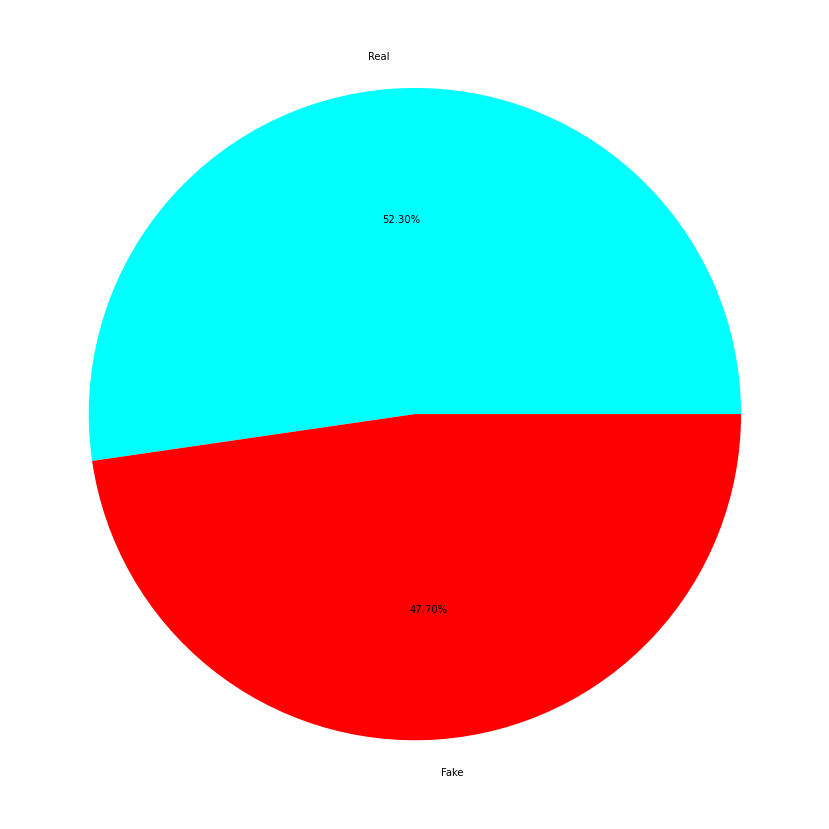

In [27]:
colors = ['cyan', 'red']
plt.figure(figsize=(20,15))
plt.pie(data['Target'].value_counts(), labels=['Real', 'Fake'], colors=colors, autopct="%0.2f%%") #pie plot of the data
plt.show()


# The data indicates that there exists a minor disparity in the dataset, with the number of real data instances exceeding that of the fake news instances.

In [28]:
# Download the 'punkt' package from the NLTK library
"""the Punkt library is a pre-trained unsupervised machine learning model that can segment raw text into sentences,
based on the context in which each sentence appears. The Punkt model has been trained on large corpora of text and 
uses a variety of features, such as punctuation and capitalization patterns, to identify sentence boundaries."""

nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /home/jawadkhattak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# Create a new column called 'NumberOfCharacters' in the DataFrame 'data' and populate it with the length of each row in the 'text' column
data['NumberOfCharacters'] = data['text'].apply(len)


In [30]:
data.sample(5) #sampling the data to see if the new variable is added

,text,Target,NumberOfCharacters
4298,WASHINGTON (Reuters) - White House spokesman S...,1,3210
4502,WASHINGTON (Reuters) - The U.S. Department of ...,1,2719
15801,The laws don t apply to the Clinton s they re ...,0,1190
5513,WASHINGTON (Reuters) - The European Union’s fo...,1,3055
9850,No class and no decorum! The always bitter Mic...,0,2216


In [31]:
# Generate descriptive statistics of the DataFrame 'data'
data.describe()


,Target,NumberOfCharacters
count,44895.000000,44895.000000
mean,0.477046,2469.187950
std,0.499478,2171.663707
min,0.000000,1.000000
25%,0.000000,1234.000000
50%,0.000000,2186.000000
75%,1.000000,3105.500000
max,1.000000,51794.000000


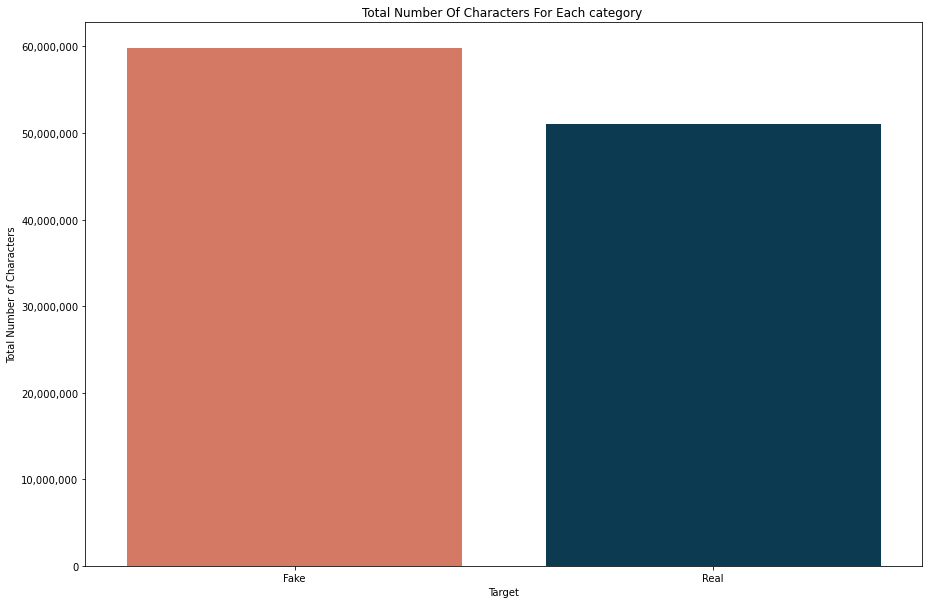

In [32]:

fig = plt.figure(figsize=(15,10))

total_chars_target_Fake = data[data['Target'] == 0]['NumberOfCharacters'].sum()
total_chars_target_Real = data[data['Target'] == 1]['NumberOfCharacters'].sum()

total = [total_chars_target_Fake, total_chars_target_Real]
targets = ['Fake', 'Real']

# Define a list of colors
colors = ["#E76F51", "#003F5C"] # Change color codes as needed

# Create a bar plot with specified colors
sns.barplot(x=targets, y=total, palette=colors)

# Set the x-axis and y-axis labels
plt.xlabel('Target')
plt.ylabel('Total Number of Characters')
plt.title('Total Number Of Characters For Each category ')

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

# Show the plot
plt.show()


In [33]:
# Add a new column to the DataFrame 'data' called 'NumberOfWords', which contains the number of words in each row of the 'text' column
data['NumberOfWords'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x)))


In [34]:
# Add a new column to the DataFrame 'data' called 'NumberOfSentences', which contains the number of sentences in each row of the 'text' column
data['NumberOfSentences'] = data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [35]:
data.sample(5)

,text,Target,NumberOfCharacters,NumberOfWords,NumberOfSentences
10122,It is becoming increasingly difficult to separ...,0,2356,416,16
4575,WASHINGTON (Reuters) - Russia mounted a campai...,1,4639,823,25
7244,A Canadian tech company is capitalizing on Don...,0,2692,507,15
21505,"A bunch of thugs, a bunch of creeps, criminal...",0,1288,269,12
13389,TOKYO (Reuters) - A Japanese court sentenced a...,1,1480,268,10


In [36]:
# Generate summary statistics for the numerical columns 'NumberOfCharacters', 'NumberOfWords', and 'NumberOfSentences'
data[['NumberOfCharacters', 'NumberOfWords', 'NumberOfSentences']].describe()


,NumberOfCharacters,NumberOfWords,NumberOfSentences
count,44895.000000,44895.000000,44895.000000
mean,2469.187950,453.459828,14.872079
std,2171.663707,394.785857,12.694070
min,1.000000,0.000000,0.000000
25%,1234.000000,226.000000,7.000000
50%,2186.000000,403.000000,13.000000
75%,3105.500000,572.000000,19.000000
max,51794.000000,9958.000000,321.000000


In [37]:
# Generate summary statistics for the numerical columns 'NumberOfCharacters', 'NumberOfWords', and 'NumberOfSentences' for fake news articles
data[data['Target'] == 0][['NumberOfCharacters', 'NumberOfWords', 'NumberOfSentences']].describe()


,NumberOfCharacters,NumberOfWords,NumberOfSentences
count,23478.000000,23478.000000,23478.000000
mean,2547.555882,470.067553,14.920010
std,2532.998914,457.175413,13.793084
min,1.000000,0.000000,0.000000
25%,1433.000000,266.000000,7.000000
50%,2166.000000,403.000000,13.000000
75%,3032.000000,562.000000,19.000000
max,51794.000000,9958.000000,288.000000


In [38]:
# Generate summary statistics for the numerical columns 'NumberOfCharacters', 'NumberOfWords', and 'NumberOfSentences' for real news articles
data[data['Target'] == 1][['NumberOfCharacters', 'NumberOfWords', 'NumberOfSentences']].describe()


,NumberOfCharacters,NumberOfWords,NumberOfSentences
count,21417.000000,21417.00000,21417.000000
mean,2383.278517,435.25391,14.819536
std,1684.835730,311.38484,11.367958
min,1.000000,0.00000,0.000000
25%,914.000000,168.00000,6.000000
50%,2222.000000,404.00000,13.000000
75%,3237.000000,589.00000,20.000000
max,29781.000000,5979.00000,321.000000


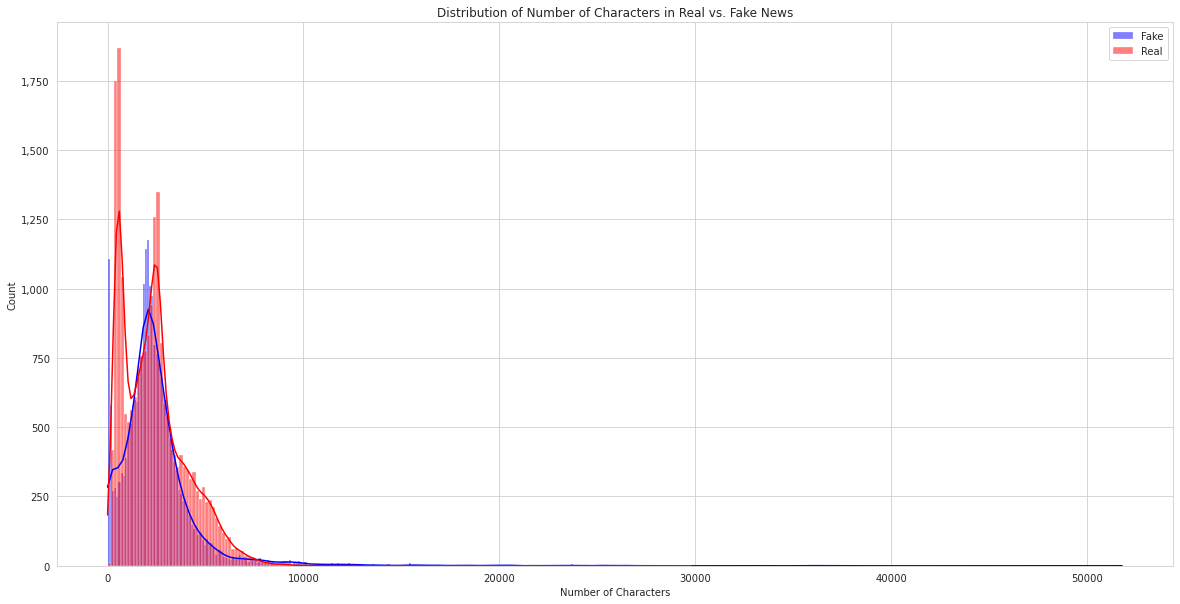

In [39]:
# Set the figure size and style
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')

# Create histograms for real and fake news articles
sns.histplot(data=data[data['Target']==0], x='NumberOfCharacters', color='blue', kde=True, alpha=0.5, label='Fake')
sns.histplot(data=data[data['Target']==1], x='NumberOfCharacters', color='red', kde=True, alpha=0.5, label='Real')

# Add labels for the x-axis and y-axis
plt.xlabel('Number of Characters')
plt.ylabel('Count')

# Add a title to the plot
plt.title('Distribution of Number of Characters in Real vs. Fake News')

# Add a legend to the plot
plt.legend()

# Format the y-axis ticks with comma separators and no decimal places
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Show the plot
plt.show()


# Number of words

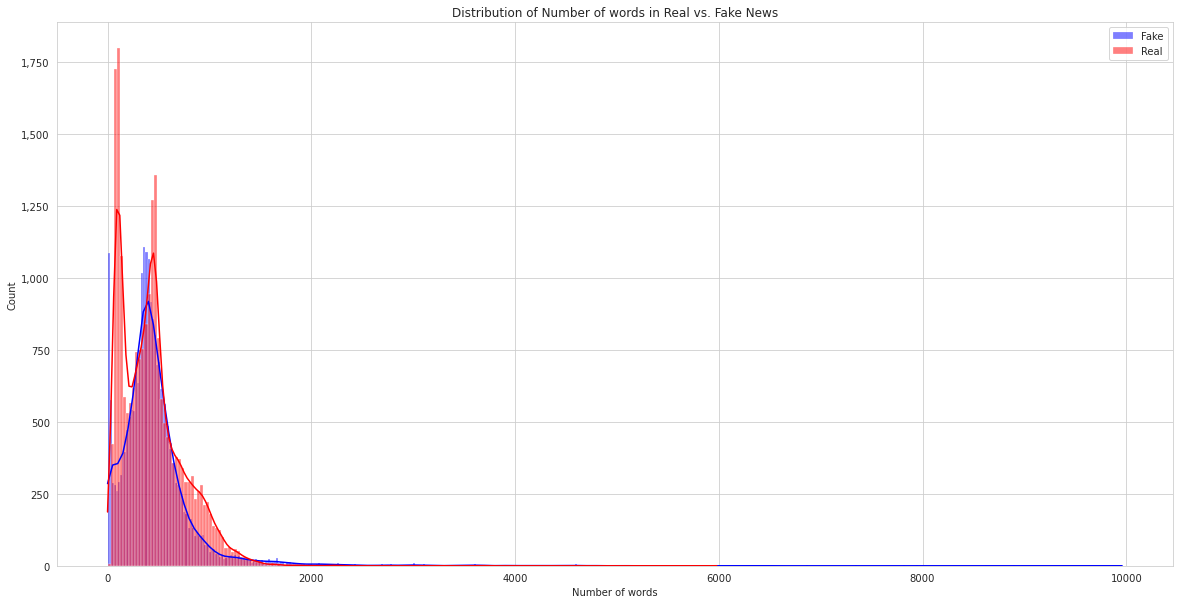

In [40]:
# Set the figure size and style
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')

# Create histograms for real and fake news articles
sns.histplot(data=data[data['Target']==0], x='NumberOfWords', color='blue', kde=True, alpha=0.5, label='Fake')
sns.histplot(data=data[data['Target']==1], x='NumberOfWords', color='red', kde=True, alpha=0.5, label='Real')

# Add labels for the x-axis and y-axis
plt.xlabel('Number of words')
plt.ylabel('Count')

# Add a title to the plot
plt.title('Distribution of Number of words in Real vs. Fake News')

# Add a legend to the plot
plt.legend()

# Format the y-axis ticks with comma separators and no decimal places
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Show the plot
plt.show()


In [41]:
data.sample(5)

,text,Target,NumberOfCharacters,NumberOfWords,NumberOfSentences
20613,Watching this video will help anyone who is cu...,0,3022,535,15
9722,"BURLINGAME, Calif. (Reuters) - U.S. presidenti...",1,3562,670,21
9788,Watching sports on TV or going to a football s...,0,2137,395,9
8179,"During a campaign stop, Republican primary can...",0,1961,371,20
4800,WASHINGTON (Reuters) - U.S. President Donald T...,1,438,85,3


Observation: The pairplot above shows that number of words, sentences and characters are bigger and longer in fake news compared to real news

/tmp/ipykernel_9567/2123422719.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


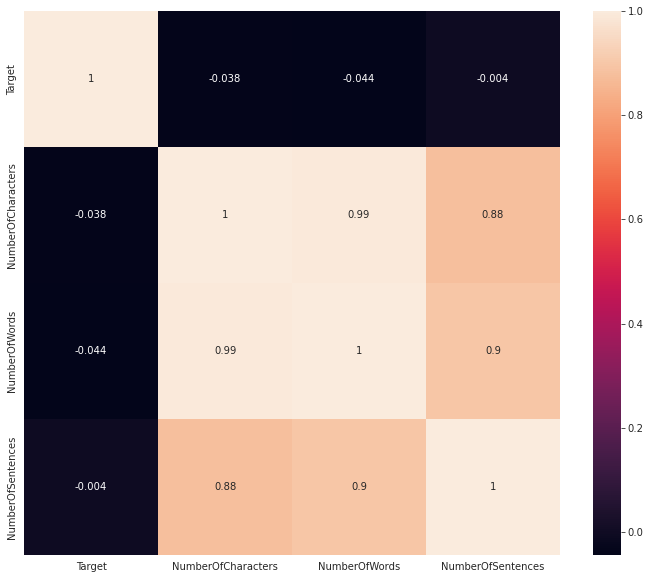

In [42]:
# creates a heatmap of the correlation matrix of the dataset using the seaborn library.
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

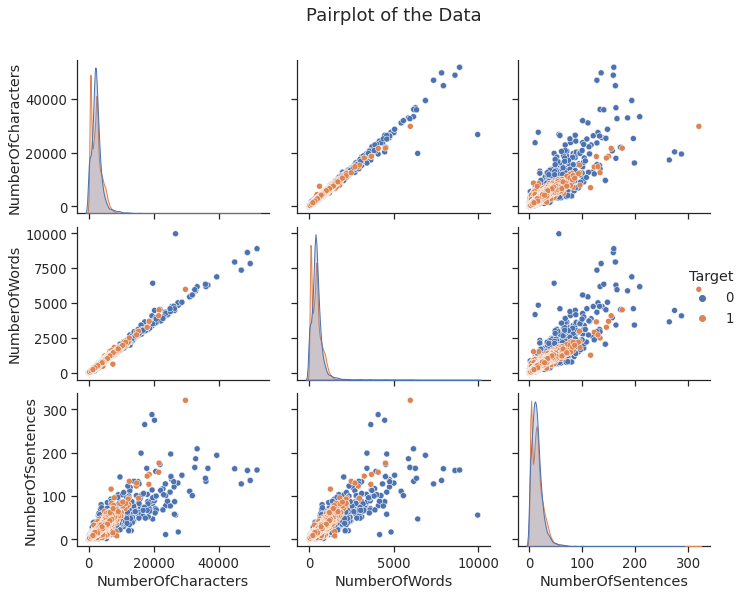

In [43]:
# Reset the index of the DataFrame to avoid duplicate labels
data = data.reset_index(drop=True)

# Set plot style
sns.set(style='ticks', font_scale=1.2)

# Create the pairplot with hue=Target
plot = sns.pairplot(data, hue='Target', height=2.5, aspect=1.2)

# Add title and adjust plot margins
plot.fig.suptitle('Pairplot of the Data', fontsize=18, y=1.05)
plot.fig.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)

# Show the plot
plt.show()

# Data Preprocessing

In [44]:
data.sample(5)

,text,Target,NumberOfCharacters,NumberOfWords,NumberOfSentences
4666,"Ordinarily, it s not cool to go after a presid...",0,2220,421,8
28711,WASHINGTON (Reuters) - U.S. President Donald T...,1,3916,726,21
43600,SEOUL (Reuters) - South Korean President Moon ...,1,405,72,2
32460,WASHINGTON (Reuters) - U.S. President Barack O...,1,1821,332,8
8958,"To the modern conservative revolutionary, th...",0,2238,416,7


In [45]:
# download the list of stop words from the nltk library
nltk.download('stopwords')

# retrieve the English stop words from the downloaded resource
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jawadkhattak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
"""The PorterStemmer is a widely used algorithm for stemming words in the English language. Stemming is the process of
reducing a word to its base or root form, which helps to reduce the size of the vocabulary and group together related words.
For example, the words "running", "runs", and "runner" all have the same stem of "run". 
The "ps" variable can be used later to perform stemming on words in a text."""

ps = PorterStemmer()

In [47]:
def transform_text(text):
    # convert text to lowercase
    text = text.lower()
    
    # tokenize the text into individual words
    text = nltk.word_tokenize(text)
    
    # create an empty list to store processed words
    y = []
    
    # loop through each word in the text
    for i in text:
        # check if the word is alphanumeric
        if i.isalnum():
            # if the word is alphanumeric, append it to the list
            y.append(i)
    
    # replace the original text list with the processed list
    text = y[:]
    # clear the processed list
    y.clear()
    
    # loop through each word in the text
    for i in text:
        # check if the word is not a stop word or punctuation
        if i not in stopwords.words('english') and i not in string.punctuation:
            # if the word is not a stop word or punctuation, append it to the list
            y.append(i)
    
    # replace the original text list with the processed list
    text = y[:]
    # clear the processed list
    y.clear()
    
    # loop through each word in the text
    for i in text:
        # stem the word using the PorterStemmer algorithm
        y.append(ps.stem(i))
    
    # join the stemmed words back into a string
    return " ".join(y)


In [48]:
# set the maximum column width of the display to None, to show the full text of the row
with pd.option_context('display.max_colwidth', None):
    # print the text of the row with index 1
    print(data['text'][1])


House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Tru

In [49]:
# sample testing
transform_text("""House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Trump ran with him being merely a coffee boy.In May 2016, Papadopoulos revealed to Australian diplomat Alexander Downer that Russian officials were shopping around possible dirt on then-Democratic presidential nominee Hillary Clinton. Exactly how much Mr. Papadopoulos said that night at the Kensington Wine Rooms with the Australian, Alexander Downer, is unclear,  the report states.  But two months later, when leaked Democratic emails began appearing online, Australian officials passed the information about Mr. Papadopoulos to their American counterparts, according to four current and former American and foreign officials with direct knowledge of the Australians  role. Papadopoulos pleaded guilty to lying to the F.B.I. and is now a cooperating witness with Special Counsel Robert Mueller s team.This isn t a presidency. It s a badly scripted reality TV show.Photo by Win McNamee/Getty Images.
1    WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition of anonymity. In September, the Pentagon said it had created a panel of senior officials to study how to implement a directive by Trump to prohibit transgender individuals from serving. The Defense Department has until Feb. 21 to submit a plan to Trump. Lawyers representing currently-serving transgender service members and aspiring recruits said they had expected the administration to appeal the rulings to the conservative-majority Supreme Court, but were hoping that would not happen. Pentagon spokeswoman Heather Babb said in a statement: “As mandated by court order, the Department of Defense is prepared to begin accessing transgender applicants for military service Jan. 1. All applicants must meet all accession standards.” Jennifer Levi, a lawyer with gay, lesbian and transgender advocacy group GLAD, called the decision not to appeal “great news.” “I’m hoping it means the government has come to see that there is no way to justify a ban and that it’s not good for the military or our country,” Levi said. Both GLAD and the American Civil Liberties Union represent plaintiffs in the lawsuits filed against the administration. In a move that appealed to his hard-line conservative supporters, Trump announced in July that he would prohibit transgender people from serving in the military, reversing Democratic President Barack Obama’s policy of accepting them. Trump said on Twitter at the time that the military “cannot be burdened with the tremendous medical costs and disruption that transgender in the military would entail.” Four federal judges - in Baltimore, Washington, D.C., Seattle and Riverside, California - have issued rulings blocking Trump’s ban while legal challenges to the Republican president’s policy proceed. The judges said the ban would likely violate the right under the U.S. Constitution to equal protection under the law. The Pentagon on Dec. 8 issued guidelines to recruitment personnel in order to enlist transgender applicants by Jan. 1. The memo outlined medical requirements and specified how the applicants’ sex would be identified and even which undergarments they would wear. The Trump administration previously said in legal papers that the armed forces were not prepared to train thousands of personnel on the medical standards needed to process transgender applicants and might have to accept “some individuals who are not medically fit for service.” The Obama administration had set a deadline of July 1, 2017, to begin accepting transgender recruits. But Trump’s defense secretary, James Mattis, postponed that date to Jan. 1, 2018, which the president’s ban then put off indefinitely. Trump has taken other steps aimed at rolling back transgender rights. In October, his administration said a federal law banning gender-based workplace discrimination does not protect transgender employees, reversing another Obama-era position. In February, Trump rescinded guidance issued by the Obama administration saying that public schools should allow transgender students to use the restroom that corresponds to their gender identity. """)

'hous intellig committe chairman devin nune go bad day assumpt like mani us christoph prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah egypt two month elect known former aid set meet world leader trump team trump ran mere coffe may 2016 papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt presidenti nomine hillari clinton exactli much papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici pass inform papadopoulo american counterpart accord four current former american foreign offici direct knowledg aust

In [50]:
# create a new column in the dataframe named 'transform_text'
# apply the transform_text function to the 'text' column of the dataframe, and store the result in the new column
data['transform_text'] = data['text'].apply(transform_text)


In [51]:
data.sample(5)

,text,Target,NumberOfCharacters,NumberOfWords,NumberOfSentences,transform_text
34503,WASHINGTON (Reuters) - Anyone seeking a table ...,1,7031,1345,47,washington reuter anyon seek tabl carmin itali...
12472,,0,1,0,0,
37050,SINGAPORE (Reuters) - Chinese President Xi Jin...,1,472,79,2,singapor reuter chines presid xi jinp told cou...
8813,The infamous conservative Republican financier...,0,2803,480,7,infam conserv republican financi charl david k...
44548,BEIRUT (Reuters) - The Syrian army and allied ...,1,399,76,2,beirut reuter syrian armi alli forc come withi...


In [52]:
#code to create a worldcloud to see the most frequent used words in the the real and fake dataset 
wc = WordCloud(width=700,height=500,min_font_size=10,background_color='white', colormap='rainbow') 

In [53]:
# Generate wordcloud of words for fake dataset
fake_news = wc.generate(data[data['Target'] == 0]['transform_text'].str.cat(sep=" "))

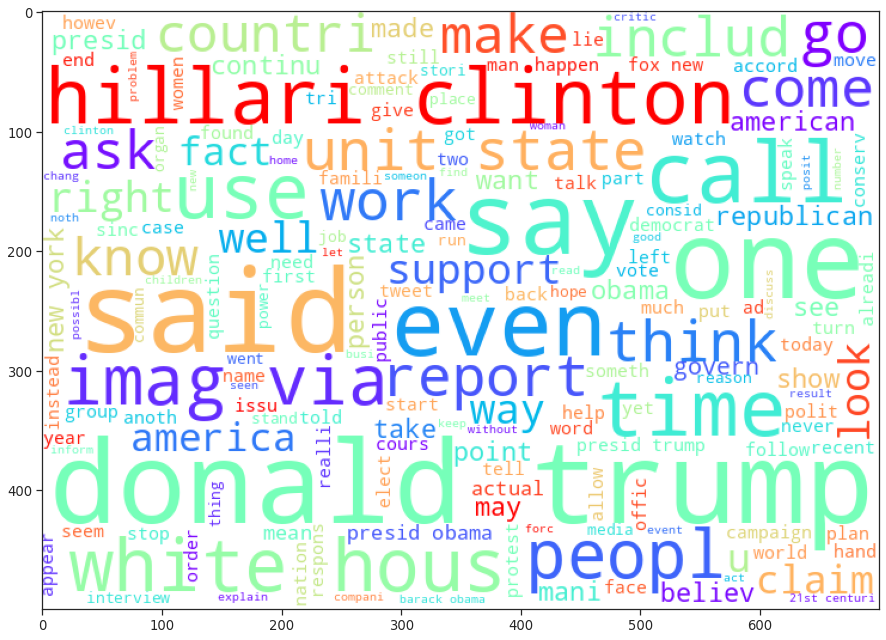

In [54]:
plt.figure(figsize=(15,12))
plt.imshow(fake_news)
plt.show()

In [55]:
# Code for creating a worldcloud of real dataset
True_news = wc.generate(data[data['Target'] == 1]['transform_text'].str.cat(sep=" "))

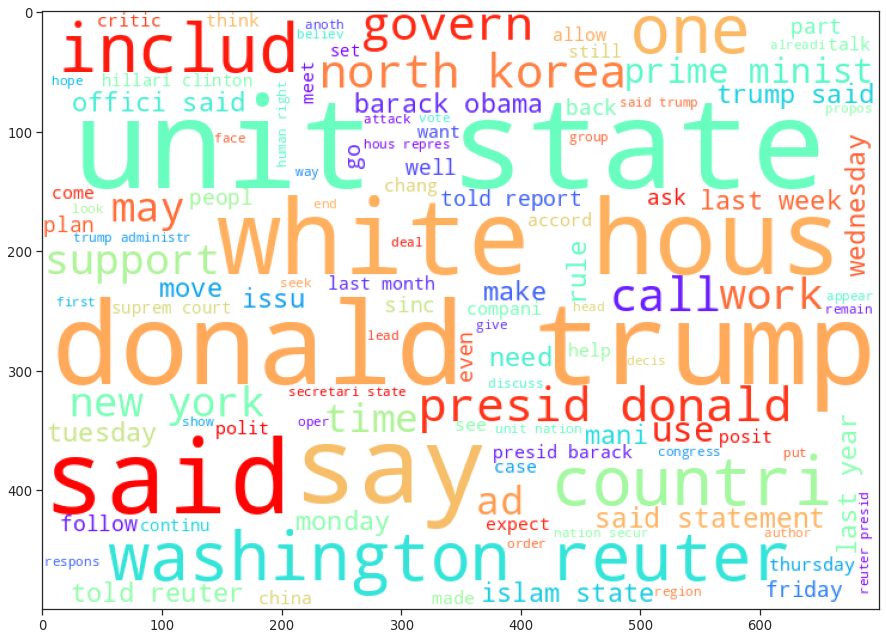

In [56]:
plt.figure(figsize=(15,12))
plt.imshow(True_news)
plt.show()

In [57]:
# create an empty list to store the corpus
fake_corpus = []

# loop through each message in the subset of rows where 'Target' is 0
for msg in data[data['Target'] == 0]['transform_text'].tolist():
    # loop through each word in the message
    for word in msg.split():
        # append the word to the corpus list
        fake_corpus.append(word)


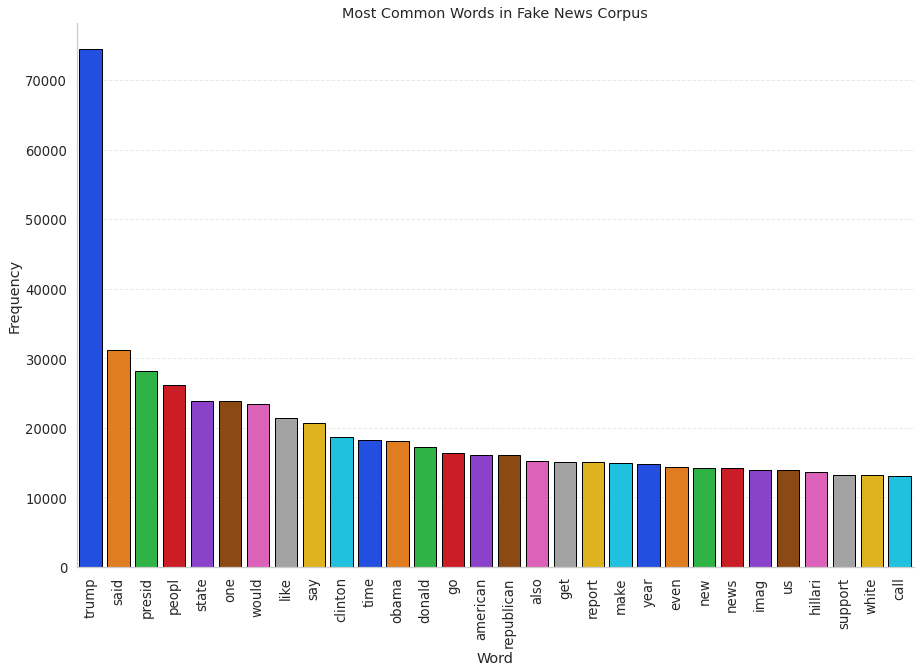

In [58]:
# Set the color palette to a list of bright and colorful colors
colors = sns.color_palette("bright", 30)

# Set the style to whitegrid for a cleaner look
sns.set_style("whitegrid")

# Set the size of the figure
plt.figure(figsize=(15,10))

# Use the Counter class to count the occurrences of each word in the Fake_corpus text corpus, and take the 30 most common words
most_common_words = Counter(fake_corpus).most_common(30)

# Convert the list of most common words into a Pandas DataFrame
word_count_df = pd.DataFrame(most_common_words)

# Create a bar plot using Seaborn, with the specified colors and edge color
ax = sns.barplot(x=word_count_df[0], y=word_count_df[1], palette=colors, edgecolor='black')

# Set the title and axis labels
plt.title("Most Common Words in Fake News Corpus")
plt.xlabel("Word")
plt.ylabel("Frequency")

# Rotate the x-axis labels vertically for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Add a grid to the plot
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# Remove the top and right spines
sns.despine(top=True, right=True)

# Show the plot
plt.show()


In [59]:
# create an empty list to store the corpus
True_corpus = []

# loop through each message in the subset of rows where 'Target' is 1
for msg in data[data['Target'] == 1]['transform_text'].tolist():
    # loop through each word in the message
    for word in msg.split():
        # append the word to the corpus list
        True_corpus.append(word)


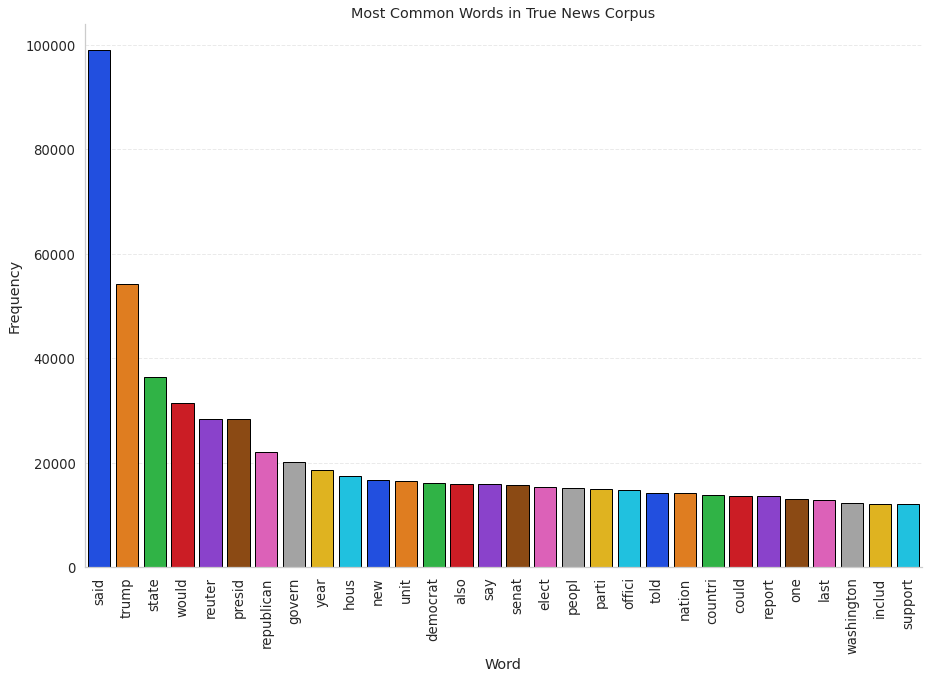

In [60]:

# Set the color palette to a list of bright and colorful colors
colors = sns.color_palette("bright", 30)

# Set the figure size
plt.figure(figsize=(15,10))

# Use the Counter class to count the occurrences of each word in the True_corpus text corpus, and take the 30 most common words
most_common_words = Counter(True_corpus).most_common(30)

# Convert the list of most common words into a Pandas DataFrame
word_count_df = pd.DataFrame(most_common_words)

# Create a bar plot using Seaborn, with the specified colors and edge color
ax = sns.barplot(x=word_count_df[0], y=word_count_df[1], palette=colors, edgecolor='black')

# Set the title and axis labels
plt.title("Most Common Words in True News Corpus")
plt.xlabel("Word")
plt.ylabel("Frequency")

# Rotate the x-axis labels vertically for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Add a grid to the plot
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# Remove the top and right spines
sns.despine(top=True, right=True)

# Show the plot
plt.show()


# Model building

In [61]:
# create a CountVectorizer object
cv = CountVectorizer()

# create a TfidfVectorizer object with a maximum of 3000 features
tfidf = TfidfVectorizer(max_features=7000)


In [62]:
# use the tfidf vectorizer to transform the 'transform_text' column of the 'data' dataframe
X = tfidf.fit_transform(data['transform_text']).toarray()


In [63]:
# create a NumPy array 'y' that contains the target variable values
y = data['Target'].values


In [64]:
X.shape


(44895, 7000)

In [65]:
y.shape

(44895,)

In [66]:
# split the data into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


In [67]:
gnb = GaussianNB() # create a GaussianNB classifier and fit it to the training data
bnb = BernoulliNB() # create a BernoulliNB classifier and fit it to the training data

In [68]:
# fit the Gaussian Naive Bayes classifier to the training data
gnb.fit(X_train,y_train)

# make predictions on the test data
y_pred1 = gnb.predict(X_test)

# compute and print the accuracy score of the classifier

print("Gaussian Naive Bayes accuracy:", accuracy_score(y_test,y_pred1))

# compute and print the confusion matrix of the classifier

print("Gaussian Naive Bayes confusion matrix:\n", confusion_matrix(y_test,y_pred1))

# compute and print the precision score of the classifier

print("Gaussian Naive Bayes precision score:", precision_score(y_test,y_pred1))


Gaussian Naive Bayes accuracy: 0.9016594275531796
Gaussian Naive Bayes confusion matrix:
 [[4286  425]
 [ 458 3810]]
Gaussian Naive Bayes precision score: 0.8996458087367178


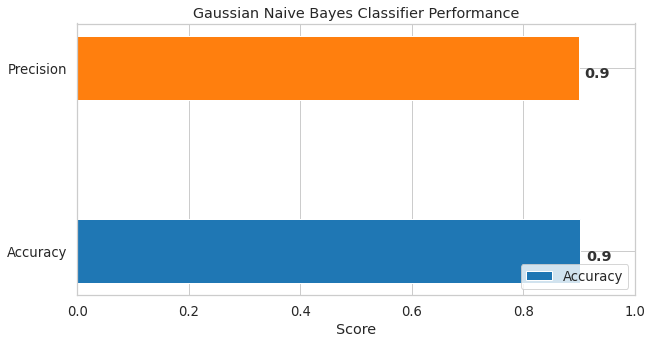

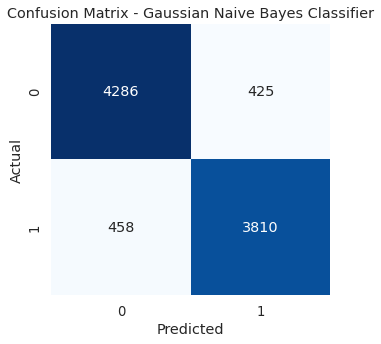

In [69]:

# compute the accuracy, confusion matrix, and precision score of the classifier
accuracy = accuracy_score(y_test,y_pred1)
conf_matrix = confusion_matrix(y_test,y_pred1)
precision = precision_score(y_test,y_pred1)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,5))
bar_width = 0.35
labels = ['Accuracy', 'Precision']
values = [accuracy, precision]

# plot the values as horizontal bars
ax.barh(labels, values, bar_width, color=['#1f77b4', '#ff7f0e'])

# add labels to the bars
for i, v in enumerate(values):
    ax.text(v + 0.01, i - 0.05, str(round(v, 2)), color='#333333', fontweight='bold')

# set the x-axis range and tick labels
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# set the title and axis labels
ax.set_title('Gaussian Naive Bayes Classifier Performance')
ax.set_xlabel('Score')

# add a legend
ax.legend(['Accuracy', 'Precision'], loc='lower right')

# show the plot
plt.show()

# plot the confusion matrix as a heatmap
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False, fmt='g')
plt.title('Confusion Matrix - Gaussian Naive Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [70]:
# fit the Bernoulli Naive Bayes classifier to the training data
bnb.fit(X_train,y_train)

# make predictions on the test data
y_pred3 = bnb.predict(X_test)

# compute and print the accuracy score of the classifier
print("Bernoulli Naive Bayes accuracy:", accuracy_score(y_test,y_pred3))

# compute and print the confusion matrix of the classifier
print("Bernoulli Naive Bayes confusion matrix:\n", confusion_matrix(y_test,y_pred3))

# compute and print the precision score of the classifier
print("Bernoulli Naive Bayes precision score:", precision_score(y_test,y_pred3))


Bernoulli Naive Bayes accuracy: 0.9605746742398931
Bernoulli Naive Bayes confusion matrix:
 [[4519  192]
 [ 162 4106]]
Bernoulli Naive Bayes precision score: 0.9553280595625873


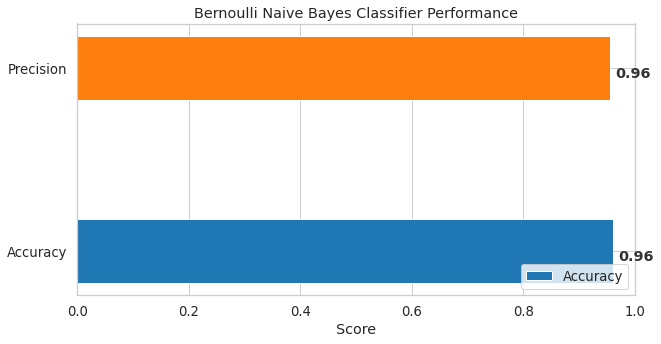

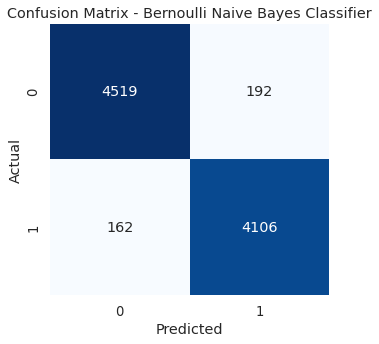

In [71]:
# compute the accuracy, confusion matrix, and precision score of the classifier
accuracy = accuracy_score(y_test, y_pred3)
conf_matrix = confusion_matrix(y_test, y_pred3)
precision = precision_score(y_test, y_pred3)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
labels = ['Accuracy', 'Precision']
values = [accuracy, precision]

# plot the values as horizontal bars
ax.barh(labels, values, bar_width, color=['#1f77b4', '#ff7f0e'])

# add labels to the bars
for i, v in enumerate(values):
    ax.text(v + 0.01, i - 0.05, str(round(v, 2)), color='#333333', fontweight='bold')

# set the x-axis range and tick labels
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# set the title and axis labels
ax.set_title('Bernoulli Naive Bayes Classifier Performance')
ax.set_xlabel('Score')

# add a legend
ax.legend(['Accuracy', 'Precision'], loc='lower right')

# show the plot
plt.show()

# plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False, fmt='g')
plt.title('Confusion Matrix - Bernoulli Naive Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [72]:
# Creating multiple classifiers with different hyperparameters for classification

# Support Vector Machine classifier with 'sigmoid' kernel and gamma = 1.0
svc = SVC(kernel='sigmoid', gamma=1.0)

# K-Nearest Neighbors classifier
knc = KNeighborsClassifier()

# Decision Tree classifier with maximum depth of 5
dtc = DecisionTreeClassifier(max_depth=5)

# Logistic Regression classifier with 'liblinear' solver and 'l1' penalty
lrc = LogisticRegression(solver='liblinear', penalty='l1')

# Random Forest classifier with 50 estimators and random state of 2
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

# AdaBoost classifier with 50 estimators and random state of 2
abc = AdaBoostClassifier(n_estimators=50, random_state=2)

# Bagging classifier with 50 estimators and random state of 2
bc = BaggingClassifier(n_estimators=50, random_state=2)

# Extra Trees classifier with 50 estimators and random state of 2
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

# Gradient Boosting Decision Tree classifier with 50 estimators and random state of 2
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

# XGBoost classifier with 50 estimators and random state of 2
xgb = XGBClassifier(n_estimators=50,random_state=2)


In [73]:
# Define a dictionary of classifiers with their respective names as keys
clfs = {
    'SVC' : svc,             # Support Vector Classifier
    'KN' : knc,              # K-Nearest Neighbors Classifier
    'DT': dtc,              # Decision Tree Classifier
    'LR': lrc,              # Logistic Regression Classifier
    'RF': rfc,              # Random Forest Classifier
    'AdaBoost': abc,        # AdaBoost Classifier
    'BgC': bc,              # Bagging Classifier
    'ETC': etc,             # Extra Trees Classifier
    'GBDT':gbdt,            # Gradient Boosting Decision Tree Classifier
    'xgb':xgb               # Extreme Gradient Boosting Classifier
}


In [74]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    """
    Train a classifier on the given data and return accuracy and precision scores on test data.
    
    Parameters:
        clf (sklearn classifier object): A classifier object to be trained
        X_train (numpy array): Training features
        y_train (numpy array): Training labels
        X_test (numpy array): Test features
        y_test (numpy array): Test labels
    
    Returns:
        accuracy (float): Accuracy score of the trained classifier on the test data
        precision (float): Precision score of the trained classifier on the test data
    """
    # Fit the classifier on the training data
    clf.fit(X_train,y_train)
    # Predict the labels on the test data
    y_pred = clf.predict(X_test)
    # Calculate the accuracy score on the test data
    accuracy = accuracy_score(y_test,y_pred)
    # Calculate the precision score on the test data
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision


In [75]:
"""The train_classifier() function takes a classifier clf, training features X_train and labels y_train, as well as testing features X_test and labels y_test.
It fits the classifier on the training data and predicts the labels on the testing data. It returns the accuracy and precision score of the classifier on the testing data."""
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9889742733043769, 0.9848802046987671)

In [76]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    # Train the classifier and obtain the accuracy and precision scores
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    # Append the current accuracy and precision scores to their respective lists
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9889742733043769
Precision -  0.9848802046987671
For  KN
Accuracy -  0.730816349259383
Precision -  0.9159550561797752
For  DT
Accuracy -  0.9953224189776144
Precision -  0.992081974848626
For  LR
Accuracy -  0.9927608865129747
Precision -  0.989517819706499
For  RF
Accuracy -  0.9958792738612318
Precision -  0.9948538011695907
For  AdaBoost
Accuracy -  0.9947655640939971
Precision -  0.9920727442294242
For  BgC
Accuracy -  0.9975498385120838
Precision -  0.9976558837318331
For  ETC
Accuracy -  0.9876378215836953
Precision -  0.9828106852497096
For  GBDT
Accuracy -  0.994988306047444
Precision -  0.9923058988109116
For  xgb
Accuracy -  0.9982180643724246
Precision -  0.9976591760299626


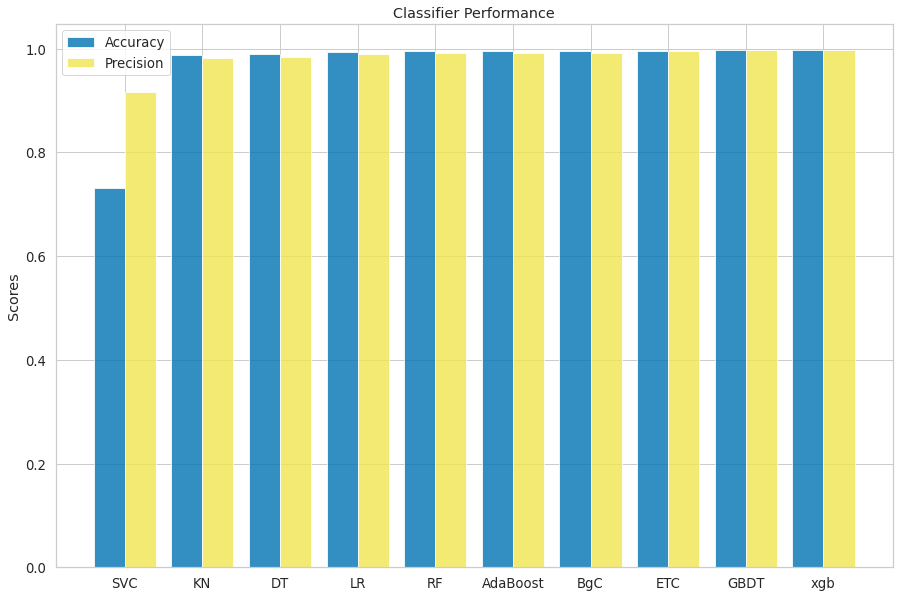

In [102]:
# Set up the colors for the bars
colors = ['#0072B2', '#F0E551']

# Create a bar plot for accuracy scores
plt.figure(figsize=(15,10))
plt.bar(y_pos-0.2, accuracy, width=0.4, align='center', alpha=0.8, color=colors[0], label='Accuracy')
plt.bar(y_pos+0.2, precision, width=0.4, align='center', alpha=0.8, color=colors[1], label='Precision')
plt.xticks(y_pos, classifiers)
plt.ylabel('Scores')
plt.title('Classifier Performance')
plt.legend()
plt.show()


In [103]:
# This line creates a new pandas DataFrame called performance_df
# The DataFrame contains three columns: Algorithm, Accuracy, and Precision
# The values for 'Algorithm' are the keys from the dictionary 'clfs'
# The values for 'Accuracy' are stored in the list 'accuracy_scores'
# The values for 'Precision' are stored in the list "precision_scores"
# The DataFrame is then sorted in descending order by the values in the 'Precision' column.

performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [104]:
performance_df #Dataframe

,Algorithm,Accuracy,Precision
9,xgb,0.998218,0.997659
6,BgC,0.997550,0.997656
4,RF,0.995879,0.994854
8,GBDT,0.994988,0.992306
2,DT,0.995322,0.992082
5,AdaBoost,0.994766,0.992073
3,LR,0.992761,0.989518
0,SVC,0.988974,0.984880
7,ETC,0.987638,0.982811
1,KN,0.730816,0.915955


In [105]:
# This line uses the "pd.melt()" function to create a new DataFrame called "performance_df1"
# The function transforms the "performance_df" DataFrame from a wide format to a long format
# The 'Algorithm' column is set as the identifier variable using the "id_vars" parameter
# The 'Accuracy' and 'Precision' columns are "melted" and combined into a single column called "variable"
# The values in the 'Accuracy' and 'Precision' columns are moved to a new column called "value"
# The resulting DataFrame has three columns: 'Algorithm', 'variable', and 'value'


performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [106]:
performance_df1 #dataframe

,Algorithm,variable,value
0,xgb,Accuracy,0.998218
1,BgC,Accuracy,0.997550
2,RF,Accuracy,0.995879
3,GBDT,Accuracy,0.994988
4,DT,Accuracy,0.995322
5,AdaBoost,Accuracy,0.994766
6,LR,Accuracy,0.992761
7,SVC,Accuracy,0.988974
8,ETC,Accuracy,0.987638
9,KN,Accuracy,0.730816


In [110]:
# The following code creates a new pandas dataframe named 'temp_df'.
# The dataframe has three columns named 'Algorithm', 'Accuracy_max_ft_7000', and 'Precision_max_ft_7000'.
# The values in the 'Algorithm' column are taken from the keys of a dictionary called 'clfs'.
# The values in the 'Accuracy_max_ft_7000' and 'Precision_max_ft_7000' columns are taken from 'accuracy_scores' and 'precision_scores' lists, respectively.
# The 'temp_df' dataframe is sorted in descending order based on the values in the 'Precision_max_ft_7000' column

temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_7000':accuracy_scores,'Precision_max_ft_7000':precision_scores}).sort_values('Precision_max_ft_7000',ascending=False)

In [111]:
# The following code creates a new pandas dataframe named 'temp_df'.
# The dataframe has three columns named 'Algorithm', 'Accuracy_scaling', and 'Precision_scaling'.
# The values in the 'Algorithm' column are taken from the keys of a dictionary called 'clfs'.
# The values in the 'Accuracy_scaling' and 'Precision_scaling' columns are taken from 'accuracy_scores' and 'precision_scores' lists, respectively.
# The 'temp_df' dataframe is sorted in descending order based on the values in the 'Precision_scaling' column.

temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [112]:
# The following code merges two pandas dataframes, 'performance_df' and 'temp_df', into a new dataframe named 'new_df'.
# The merge is done based on the 'Algorithm' column of both dataframes, using the 'merge' function from pandas library.
# The resulting dataframe will have all the columns from both dataframes.

new_df = performance_df.merge(temp_df,on='Algorithm')

In [113]:
# The following code merges two pandas dataframes, 'new_df' and 'temp_df', into a new dataframe named 'new_df_scaled'.
# The merge is done based on the 'Algorithm' column of both dataframes, using the 'merge' function from pandas library.
# The resulting dataframe will have all the columns from both dataframes, with suffixes "_x" and "_y" added to columns with the same names to differentiate between the two original dataframes.

new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [114]:
# The following code creates a new pandas dataframe named 'temp_df'.
# The dataframe has three columns named 'Algorithm', 'Accuracy_num_chars', and 'Precision_num_chars'.
# The values in the 'Algorithm' column are taken from the keys of a dictionary called 'clfs'.
# The values in the 'Accuracy_num_chars' and 'Precision_num_chars' columns are taken from 'accuracy_scores' and 'precision_scores' lists, respectively.
# The 'temp_df' dataframe is sorted in descending order based on the values in the 'Precision_num_chars' column.

temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [115]:
# The following code merges two pandas dataframes, 'new_df_scaled' and 'temp_df', based on the 'Algorithm' column.
# The resulting dataframe is not assigned to any variable, so it won't be stored or used later in the code.
# The merge is done using the 'merge' function from pandas library, which merges the two dataframes based on the common 'Algorithm' column.

new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,xgb,0.998218,0.997659,0.998218,0.997659,0.998218,0.997659,0.998218,0.997659
1,BgC,0.997550,0.997656,0.997550,0.997656,0.997550,0.997656,0.997550,0.997656
2,RF,0.995879,0.994854,0.995879,0.994854,0.995879,0.994854,0.995879,0.994854
3,GBDT,0.994988,0.992306,0.994988,0.992306,0.994988,0.992306,0.994988,0.992306
4,DT,0.995322,0.992082,0.995322,0.992082,0.995322,0.992082,0.995322,0.992082
5,AdaBoost,0.994766,0.992073,0.994766,0.992073,0.994766,0.992073,0.994766,0.992073
6,LR,0.992761,0.989518,0.992761,0.989518,0.992761,0.989518,0.992761,0.989518
7,SVC,0.988974,0.984880,0.988974,0.984880,0.988974,0.984880,0.988974,0.984880
8,ETC,0.987638,0.982811,0.987638,0.982811,0.987638,0.982811,0.987638,0.982811
9,KN,0.730816,0.915955,0.730816,0.915955,0.730816,0.915955,0.730816,0.915955


In [117]:
# The 'pickle.dump' function from the pickle library is used to write the objects to binary files in write mode ('wb').
# The 'vectorizer.pkl' file will contain the 'tfidf' object, and 'model.pkl' will contain the 'xgb' object.
# These files can be loaded later using the 'pickle.load' function.

pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(xgb,open('model.pkl','wb'))